In [548]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

In [482]:
df = pd.read_csv('Tony_data/merged_all_data_US_with_lfp.csv')
df['month'] = pd.to_datetime(df['month'], errors='coerce')  # Safely convert to datetime
df = df.sort_values('month')

df_grouped = df.groupby('month').mean(numeric_only=True)
df_grouped = df_grouped.drop(columns=["state"], errors='ignore')
df_grouped = df_grouped.reset_index()  # Keep 'month' as column

In [542]:
imputer = SimpleImputer(missing_values=np.nan)
data_imputed = pd.DataFrame(imputer.fit_transform(df_grouped.drop(columns=['month'])),
                            columns=df_grouped.columns.drop('month'))
data_imputed['month'] = df_grouped['month'].values

# Step 4: Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data_imputed.drop(columns=['month']))
df_scaled = pd.DataFrame(scaled_features, columns=data_imputed.columns.drop('month'))
df_scaled['month'] = data_imputed['month'].values
train_cutoff_date = pd.to_datetime('2020-01-01')
# Keep a copy of just dates
# Step 1: Prepare the full scaled DataFrame (already done earlier)
df_scaled = df_scaled.sort_values('month').reset_index(drop=True)

# Step 2: Split index lengths based on 7:2:1 ratio
total_len = len(df_scaled)
train_end = int(0.7 * total_len)
val_end = int(0.9 * total_len)

# Save the 'month' column separately for later plotting
train_dates = df_scaled.loc[20:train_end, 'month'].reset_index(drop=True)
val_dates = df_scaled.loc[train_end+1:val_end, 'month'].reset_index(drop=True)
test_dates = df_scaled.loc[val_end+1:, 'month'].reset_index(drop=True)
all_date = df_scaled.loc[0:total_len, 'month'].reset_index(drop=True)

# Step 3: Drop 'month' for LSTM input
df_train = df_scaled.iloc[:train_end].drop(columns=['month']).reset_index(drop=True)
df_val = df_scaled.iloc[train_end:val_end].drop(columns=['month']).reset_index(drop=True)
df_test = df_scaled.iloc[val_end:].drop(columns=['month']).reset_index(drop=True)
df_scaled = df_scaled.drop(columns=['month']).reset_index(drop=True)







In [484]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['Unemployment Rate']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [547]:
window = 20
X_train, y_train = singleStepSampler(df_train, window)
X_val, y_val = singleStepSampler(df_val, window)
X_test, y_test = singleStepSampler(df_test, window)
X_all = singleStepSampler(df_scaled,window)

# Step 5: Ensure all arrays are float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [544]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# Build the LSTM model
multivariate_lstm = Sequential()
multivariate_lstm.add(LSTM(456, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(Dropout(0.2))
multivariate_lstm.add(Dense(100, activation='linear'))
multivariate_lstm.add(Dense(1, activation='linear'))  # Predicting single target value

# Compile the model
multivariate_lstm.compile(
    loss='mean_squared_error',
    optimizer=Adam(),
    metrics=['mae']
)

# Train the model
history = multivariate_lstm.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)





/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0436 - mae: 0.1574 - val_loss: 0.0270 - val_mae: 0.1094
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035 - mae: 0.0479 - val_loss: 0.0219 - val_mae: 0.0751
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0251 - val_mae: 0.1049
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0257 - val_mae: 0.0935
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.8418e-04 - mae: 0.0219 - val_loss: 0.0280 - val_mae: 0.0737
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7905e-04 - mae: 0.0173 - val_loss: 0.0317 - val_mae: 0.0862
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.5561e-04 - mae: 0.0183 - val_loss: 0.0335 - val_mae: 0.0973
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.0363e-04 - mae: 0.0171 - val_loss: 0.0310 - val_mae: 0.0799
Epoch 9/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1

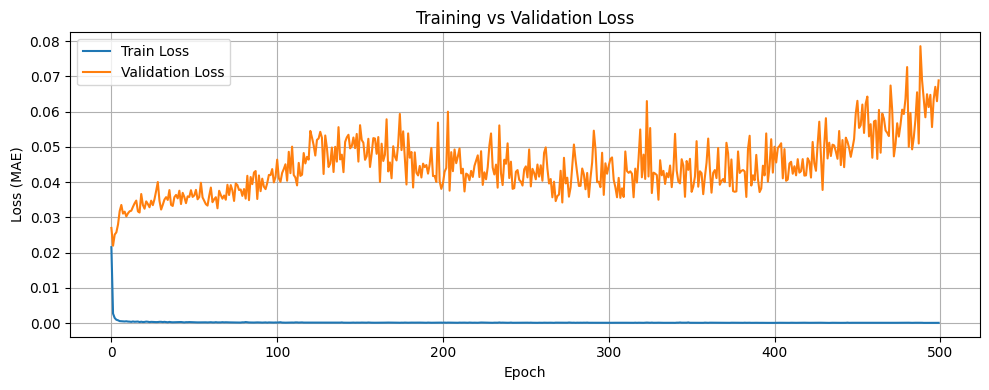

In [545]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_381
Received: inputs=('Tensor(shape=(32, 20, 5))', 'Tensor(shape=(32, 1))')
  warnings.warn(msg)


13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/opt/anaconda3/envs/RISE_PROJECT/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_381
Received: inputs=('Tensor(shape=(None, 20, 5))', 'Tensor(shape=(None, 1))')
  warnings.warn(msg)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


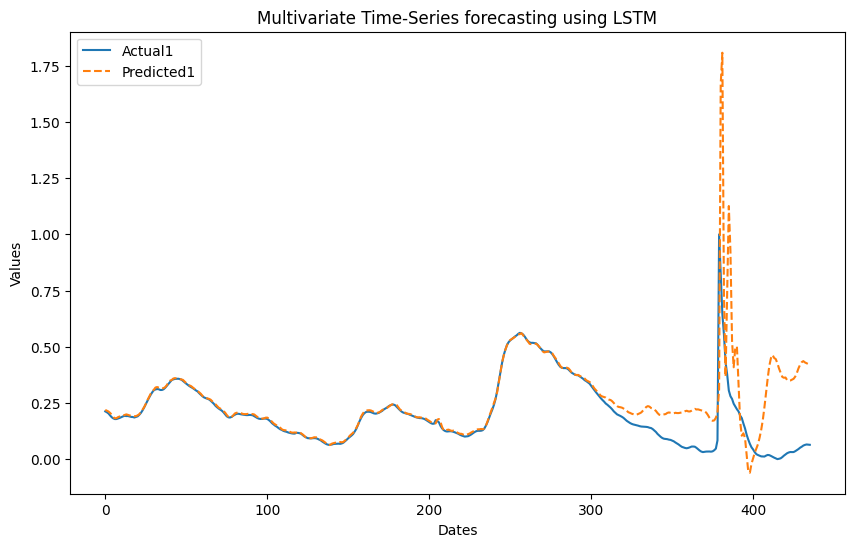

     Predicted   Actual1
0     0.218937  0.212399
1     0.215272  0.208466
2     0.211783  0.203034
3     0.205512  0.194231
4     0.197280  0.186364
..         ...       ...
431   0.436084  0.060311
432   0.430317  0.063308
433   0.426590  0.065181
434   0.422879  0.064619
435   0.419625  0.063682

[436 rows x 2 columns]


In [546]:
# Reload the data with the date index
dataFrame = pd.read_csv('Tony_data/merged_all_data_US_with_lfp.csv', parse_dates = ["month"])  # Assuming the CSV file contains a 'Date' column
dataFrame.set_index('month', inplace=True)
# Forecast Plot with Dates on X-axis
predicted_values1 = multivariate_lstm.predict(X_all)


d = {
    'Predicted': predicted_values1[:, 0],
    'Actual1': y.flatten()[-len(predicted_values1):],  # Use the actual target values
}

d = pd.DataFrame(d)
#d.index = dataFrame.index[-len(X_all):]  # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
#highlight_start = int(len(d) * 0.9)  
#highlight_end = len(d) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual1']], label=['Actual1'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted']], label=['Predicted1'], linestyle='--')




# Highlight the forecasted portion with a different color
#plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()
print(d)

In [481]:
def eval(model):
    parts = model.split("_")
    if len(parts) > 1:
        actual_col = f"Actual_{parts[1]}"
    else:
        # Fallback: assume "Actual" column is just called "Actual"
        actual_col = "Actual"
    
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[actual_col].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[actual_col].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[actual_col].to_numpy(), d[model].to_numpy())
    }

    
result = dict()
for item in ['Predicted']:
    result[item] = eval(item)

result

{'Predicted': {'MSE': 0.02558368630707264,
  'MAE': 0.08262834697961807,
  'R2': 0.13745492696762085}}

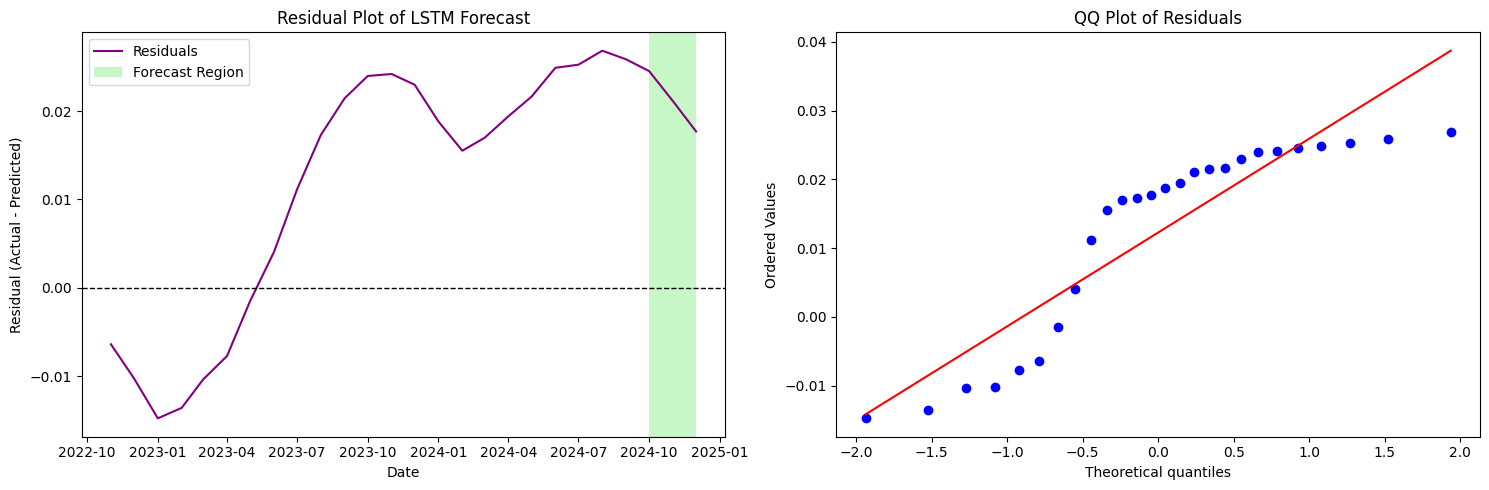

In [464]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates


# --- Calculate residuals ---
d["Residual"] = d["Actual"] - d["Predicted"]

# --- Set up side-by-side plots ---
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --- Residual Plot ---
axs[0].plot(d.index, d["Residual"], label="Residuals", color='purple')
axs[0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0].axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast Region')
axs[0].set_title("Residual Plot of LSTM Forecast")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Residual (Actual - Predicted)")
axs[0].legend()


# --- QQ Plot ---
stats.probplot(d["Residual"], dist="norm", plot=axs[1])
axs[1].set_title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()